# A second attempt

My biggest Failure was my laziness to not actually map the objects to numerical values for anything, so that will be a large focus in this second attempt.  The other thing that I would like to do is account for outliers.

I will use some variables from the previous submission, which are loaded here.  Please see submission 1 if anything is confusing.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train_dataset = pd.read_csv('data/train.csv')
test_dataset = pd.read_csv('data/test.csv')

def compute_r(var, dependent_var=None): # default dependent_var is SalePrice in this project
    dependent_var = train_dataset['SalePrice'] if dependent_var is None else dependent_var
    var_mean = np.mean(var)
    dependent_var_mean = np.mean(dependent_var)
    var_variation = [x_i - var_mean for x_i in var]
    target_variation = [y_i - dependent_var_mean for y_i in dependent_var]
    return (np.dot(var_variation, target_variation)) / (np.dot(var_variation, var_variation) * np.dot(target_variation, target_variation))**0.5

Something I missed doing before was really studying the SalePrice metric more

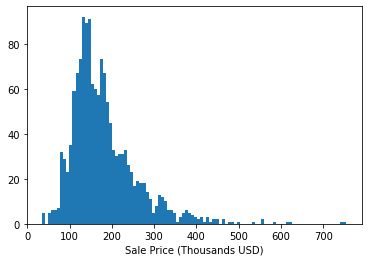

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [2]:
plt.hist([price/1000 for price in train_dataset['SalePrice']], bins=100)
plt.xlabel('Sale Price (Thousands USD)')
plt.show()

train_dataset['SalePrice'].describe()

Let's write some code to check each permutation of all the non-numerical values, and figures the best R value of those permutations

In [3]:
def get_categories(column):
    value_dist = column.value_counts()
    outlier_threshold = 0.01 # 1% of recorded represented.  
    filt = value_dist > sum(value_dist) * outlier_threshold
    return list(value_dist[filt].index)


In [4]:
def get_map_function(column): # Strategy: get the average price per category, then list in that order
    column = pd.Series(column)
    
    map_values = get_categories(column)
    mapping_dictionary = {}
    
    for index, value in enumerate(column):
        if value in map_values:
            if value in mapping_dictionary:
                mapping_dictionary[value] = mapping_dictionary[value] + train_dataset['SalePrice'][index]
            elif not pd.isnull(value):
                mapping_dictionary[value] = train_dataset['SalePrice'][index]

    
    value_dist = column.value_counts()
    for key in mapping_dictionary:
        mapping_dictionary[key] = mapping_dictionary[key] / value_dist[key]
        
    mapping_dictionary = dict(sorted(mapping_dictionary.items(), key=lambda item: item[1]))
    
    zeros = -1
    for index, key in enumerate(mapping_dictionary):
        if mapping_dictionary[key] != 0:
            mapping_dictionary[key] = np.int64(index - zeros)
        else:
            zeros += 1
    # all values that are not in final dictionary converge to 0, so account for that in returned function
    return lambda x : mapping_dictionary[x] if not pd.isnull(x) and x in mapping_dictionary else 0

get_map_function(train_dataset['ExterCond'])(np.nan)

0

Now, we finally have a function that will take all non-numerical inputs, and creates a discrete integer map.  Now, we need to apply this method to each object column in our dataset, then we can analyze more R values.

In [55]:
mapped_train = pd.DataFrame(train_dataset).copy()
for column in mapped_train:
    if mapped_train[column].dtype == np.object:        
        mapped_train[column] = mapped_train[column].apply(get_map_function(mapped_train[column]))
        
mapped_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,0,1,2,1,...,0,0,0,0,0,2,2008,2,3,208500
1,2,20,3,80.0,9600,1,0,1,2,1,...,0,0,0,0,0,5,2007,2,3,181500
2,3,60,3,68.0,11250,1,0,2,2,1,...,0,0,0,0,0,9,2008,2,3,223500
3,4,70,3,60.0,9550,1,0,2,2,1,...,0,0,0,0,0,2,2006,2,1,140000
4,5,60,3,84.0,14260,1,0,2,2,1,...,0,0,0,0,0,12,2008,2,3,250000


So now, we have every single data item, able to be expressed in a scatter plot, or have it's R statistic computed. Let's just appreciate this win by looking at one of the plots of a previously non-numerical value by sale price.

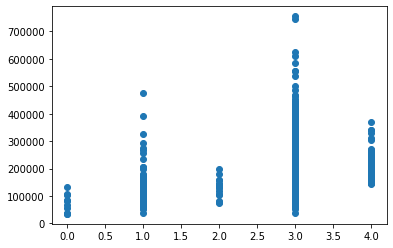

In [6]:
plt.scatter(mapped_train['MSZoning'], mapped_train['SalePrice'])
plt.show()

And, of course, we can simply compute R values with the following:

In [62]:
r_values = pd.Series([compute_r(mapped_train[value]) for value in mapped_train])
r_values.index = mapped_train.columns
filt = pd.isnull(r_values)
filt2 = abs(r_values) > 0.25
filt3 = r_values == 1
r_values = r_values[~filt][filt2][~filt3]
meaningful_values = list(r_values.index)
for index, value in enumerate(meaningful_values):
    print(f'{value}: \t {round(r_values[index], 2)}')

MSZoning: 	 0.32
LotArea: 	 0.26
LotShape: 	 0.26
Neighborhood: 	 0.67
HouseStyle: 	 0.26
OverallQual: 	 0.79
YearBuilt: 	 0.52
YearRemodAdd: 	 0.51
Exterior1st: 	 0.36
Exterior2nd: 	 0.34
MasVnrType: 	 0.4
ExterQual: 	 0.68
Foundation: 	 0.45
BsmtQual: 	 0.62
BsmtExposure: 	 0.37
BsmtFinType1: 	 0.38
BsmtFinSF1: 	 0.39
TotalBsmtSF: 	 0.61
HeatingQC: 	 0.43
CentralAir: 	 0.25
1stFlrSF: 	 0.61
2ndFlrSF: 	 0.32
GrLivArea: 	 0.71
FullBath: 	 0.56
HalfBath: 	 0.28
KitchenQual: 	 0.66
TotRmsAbvGrd: 	 0.53
Fireplaces: 	 0.47
FireplaceQu: 	 0.52
GarageType: 	 0.49
GarageFinish: 	 0.55
GarageCars: 	 0.64
GarageArea: 	 0.62
GarageQual: 	 0.27
GarageCond: 	 0.27
WoodDeckSF: 	 0.32
OpenPorchSF: 	 0.32
SaleType: 	 0.27
SaleCondition: 	 0.26


I know there's much more work to be done, but let's do a submission to see how far this improves our performance

In [47]:
meaningful_subset = mapped_train[meaningful_values]
meaningful_subset



,MSZoning,LotArea,LotShape,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition
0,3,8450,1,15,5,7,2003,2003,9,9,...,3,2,2,548,2,2,0,61,2,3
1,3,9600,1,0,4,6,1976,1976,2,3,...,3,2,2,460,2,2,298,0,2,3
2,3,11250,2,15,5,7,2001,2002,9,9,...,3,2,2,608,2,2,0,42,2,3
3,3,9550,2,16,5,7,1915,1970,3,5,...,1,1,3,642,2,2,0,35,2,1
4,3,14260,2,22,5,8,2000,2000,9,9,...,3,2,3,836,2,2,192,84,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,7917,1,13,5,6,1999,2000,9,9,...,3,2,2,460,2,2,0,40,2,3
1456,3,13175,1,12,4,6,1978,1988,7,7,...,3,1,2,500,2,2,349,0,2,3
1457,3,9042,1,16,5,7,1941,2006,10,10,...,3,2,1,252,2,2,0,60,2,3
1458,3,9717,1,9,4,5,1950,1996,2,3,...,3,1,1,240,2,2,366,0,2,3


Intercept: 
 107705.66511440865
Coefficients: 
 [ 1.36374154e+03  2.72578088e-01  5.24369613e+03  1.96370915e+03
  2.31312989e+02  1.24200951e+04 -1.25675245e+02  4.91081794e+00
  1.24038896e+03 -9.55488190e+02  2.31434335e+02  1.05840938e+04
  1.60583527e+02  6.38076010e+03  5.18968526e+03 -1.07903713e+03
  1.67677619e+01 -1.40697679e+00  1.24518191e+03  4.25570607e+03
  4.09190708e+01  2.67951307e+01  1.00277455e+01 -3.00407401e+03
  1.97834231e+03  1.11553228e+04  1.70255466e+03  2.54510773e+03
  1.03811605e+03  5.57254766e+02  7.43108631e+02  9.81929103e+03
  1.15305079e+01 -6.64385543e+03 -2.48477621e+03  2.06698241e+01
 -1.37707753e+00  3.94390102e+03  4.81020375e+03]


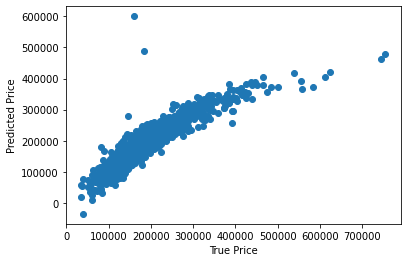

correlation of regression model prediction and trained model: 0.909670013864794


In [51]:
from sklearn import linear_model
from sklearn.metrics import log_loss
first_regr = linear_model.LinearRegression()
first_regr.fit(meaningful_subset, train_dataset['SalePrice'])
print('Intercept: \n', first_regr.intercept_)
print('Coefficients: \n', first_regr.coef_)

predicted_housing_prices = first_regr.predict(meaningful_subset)

plt.scatter(train_dataset['SalePrice'], predicted_housing_prices)
plt.ylabel('Predicted Price')
plt.xlabel('True Price')
plt.show()
print(f'correlation of regression model prediction and trained model: {compute_r(predicted_housing_prices)}')

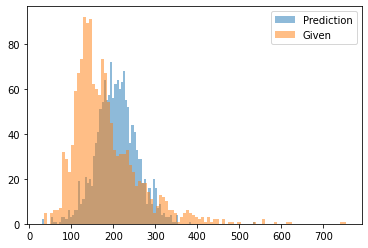

Note that the two distributions are representing different entities, predictions are of unknown values


In [59]:
test_dataset = pd.read_csv('data/test.csv')
ids = test_dataset['Id']

mapped_test = pd.DataFrame(test_dataset).copy()
for column in mapped_test:
    if mapped_test[column].dtype == np.object:        
        mapped_test[column] = mapped_test[column].apply(get_map_function(mapped_test[column]))
        
mapped_test = mapped_test[meaningful_values]
for column in mapped_test:
    for index, value in enumerate(mapped_test[column]):
        if pd.isnull(value):
            mapped_test[column][index] = 0

pred = pd.Series(first_regr.predict(mapped_test))
plt.hist([price/1000 for price in pred], bins=100, alpha=0.5, label='Prediction')
plt.hist([price/1000 for price in train_dataset['SalePrice']], bins=100, alpha=0.5, label='Given')
plt.legend()
plt.show()

pd.DataFrame({"Id": ids, "SalePrice":pred}).to_csv('prediction_submission.csv', index=False)
print('Note that the two distributions are representing different entities, predictions are of unknown values')


Well, after performing, we are now only in the bottom 11%!  Still not great, more to be done, but I feel good about the techniques that I am using! I understand a lot of the system that I am building, I know all the numbers that I am working with, and to me, that is important.  However, it's pretty clear.  I'm not giving up knowing that 89% of submissions did better than me.  (I always could just do a deep learning model, but where's the fun in that?)